### Required data

This notebooks assumes the presence of genomes in the `genomes` folder and the presence of annotations (external and JGI's) in the `annotation/external` `annotation/jgi` folders. The rest of the data is generated from these files.

TODO: Download the above-mentioned files from figshare or similar.

### Common data prep

Extract idenditifers

In [6]:
ls genomes | cut -f1 -d. > list

Prepare proteins

In [15]:
%%bash
mkdir -p peptides/{jgi,external}
cat list | xargs -I {} bash -c 'gffread -y peptides/jgi/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/jgi/{}*.gff3'
cat list | xargs -I {} bash -c 'gffread -y peptides/external/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/external/{}*.gff3'

### Pangenome expansion

In [ ]:
%%bash
mkdir pangenomeExpansion
../scripts/computePanExpansionDiamond.py peptides/jgi pangenomeExpansion/jgi_70.tsv --identity 70 --coverage 70 --threads 16
../scripts/computePanExpansionDiamond.py peptides/external pangenomeExpansion/external_70.tsv --identity 70 --coverage 70 --threads 16

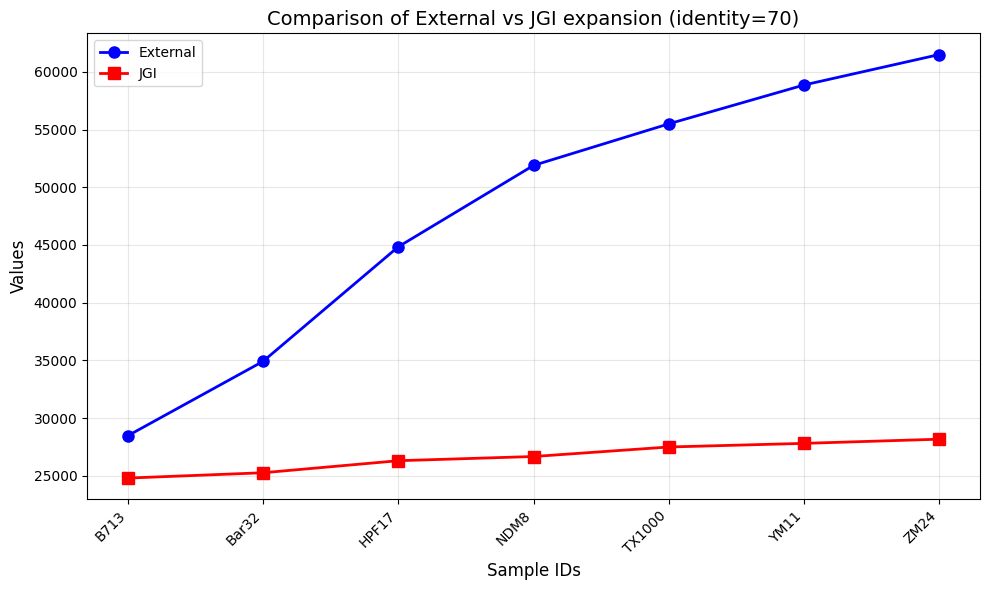

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def parse_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    identity = lines[0].strip().split('=')[1]
    
    ids = []
    values = []
    
    for line in lines[1:-1]:
        parts = line.strip().split()
        if len(parts) >= 2:
            ids.append(parts[0].replace('.primaryTrs', ''))
            values.append(int(parts[1]))
    
    return identity, ids, values

identity1, ids1, values1 = parse_file('pangenomeExpansion/external_70.tsv')
identity2, ids2, values2 = parse_file('pangenomeExpansion/jgi_70.tsv')

fig, ax = plt.subplots(figsize=(10, 6))

x_positions = np.arange(len(ids1))
ax.plot(x_positions, values1, 'b-o', label='External', markersize=8, linewidth=2)
ax.plot(x_positions, values2, 'r-s', label='JGI', markersize=8, linewidth=2)

ax.set_xticks(x_positions)
ax.set_xticklabels(ids1, rotation=45, ha='right')

ax.set_xlabel('Sample IDs', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title(f'Comparison of External vs JGI expansion (identity={identity1})', fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

### PAV estimate with get_homologues-est

Prepare the transcripts

In [28]:
%%bash
mkdir -p pav_estimate/{jgi/ests,external/ests}
cat list | xargs -I {} bash -c 'gffread -x pav_estimate/jgi/ests/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/jgi/{}*.gff3'
cat list | xargs -I {} bash -c 'gffread -x pav_estimate/external/ests/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/external/{}*.gff3'

To obtain `get_homologoues-est` results, execute the following commands in both folders (`pav_estimate/jgi` and `pav_estimate/external`). The expected runtime is several hours.

```bash
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 get_homologues-est.pl -d ests -n 64 -M -t 0
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 compare_clusters.pl -d ests_est_homologues/*_0taxa_algOMCL_e0_/ -o clusters_out -n -m
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 parse_pangenome_matrix.pl -m clusters_out/pangenome_matrix_t0.tab -s
```